# Libraries

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
#from tensorflow.keras.optimizers import rmsprop_v2
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from keras.utils.np_utils import to_categorical
import seaborn as sns

# Dataset

In [ ]:
! gdown --id 1g-722kflpW-sMKn-mAkdmLAi9gX_YxTk

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1g-722kflpW-sMKn-mAkdmLAi9gX_YxTk
To: /content/images.zip
100% 123M/123M [00:03<00:00, 34.3MB/s]


In [ ]:
!unzip /content/images.zip -d /content/

Streaming output truncated to the last 5000 lines.
 extracting: /content/images/validation/fear/9040.jpg  
 extracting: /content/images/validation/fear/9101.jpg  
 extracting: /content/images/validation/fear/911.jpg  
 extracting: /content/images/validation/fear/9179.jpg  
 extracting: /content/images/validation/fear/9205.jpg  
 extracting: /content/images/validation/fear/9232.jpg  
 extracting: /content/images/validation/fear/9251.jpg  
 extracting: /content/images/validation/fear/9261.jpg  
 extracting: /content/images/validation/fear/9281.jpg  
 extracting: /content/images/validation/fear/9302.jpg  
 extracting: /content/images/validation/fear/9333.jpg  
 extracting: /content/images/validation/fear/9369.jpg  
 extracting: /content/images/validation/fear/9370.jpg  
 extracting: /content/images/validation/fear/9474.jpg  
 extracting: /content/images/validation/fear/949.jpg  
 extracting: /content/images/validation/fear/9602.jpg  
 extracting: /content/images/validation/fear/9606.jpg  

# Read images

In [ ]:
int2emotions = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',6:'surprise',}
emotions2int = {'angry':0,'disgust':1, 'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6 }
dic = {'images':[], 'labels':[], 'purpose':[]}

for d in os.listdir('/content/images/images'):
    print(d)
    for emotion in os.listdir(f'/content/images/{d}'):
        print(emotion)
        for i in os.listdir(f'/content/images/{d}/{emotion}'):
            img = cv2.imread(f'/content/images/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)

            dic['images'].append(img)
            dic['labels'].append(emotion)

            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('V')

validation
happy
fear
sad
disgust
neutral
angry
surprise
train
happy
fear
sad
disgust
neutral
angry
surprise


In [ ]:
df = pd.DataFrame(dic)
df.head()

,images,labels,purpose
0,"[[[111], [107], [110], [109], [112], [99], [36...",happy,V
1,"[[[147], [133], [142], [143], [151], [136], [1...",happy,V
2,"[[[145], [146], [139], [135], [138], [151], [1...",happy,V
3,"[[[168], [164], [168], [119], [73], [165], [15...",happy,V
4,"[[[130], [129], [125], [136], [130], [138], [1...",happy,V


#Test Train Split

In [ ]:
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [ ]:
train_data.head()

,images,labels,purpose
7066,"[[[54], [50], [42], [35], [35], [40], [43], [4...",happy,T
7067,"[[[178], [174], [173], [175], [129], [60], [60...",happy,T
7068,"[[[57], [70], [127], [156], [161], [173], [178...",happy,T
7069,"[[[244], [243], [244], [245], [244], [243], [2...",happy,T
7070,"[[[174], [175], [175], [176], [176], [176], [1...",happy,T


In [ ]:
val_data.head()

,images,labels,purpose
0,"[[[111], [107], [110], [109], [112], [99], [36...",happy,V
1,"[[[147], [133], [142], [143], [151], [136], [1...",happy,V
2,"[[[145], [146], [139], [135], [138], [151], [1...",happy,V
3,"[[[168], [164], [168], [119], [73], [165], [15...",happy,V
4,"[[[130], [129], [125], [136], [130], [138], [1...",happy,V


In [ ]:
train_data['labels'].value_counts()

happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: labels, dtype: int64

In [ ]:
val_data['labels'].value_counts()

happy       1825
neutral     1216
sad         1139
fear        1018
angry        960
surprise     797
disgust      111
Name: labels, dtype: int64

In [ ]:
happy_df = train_data[train_data['labels']=='happy'].sample(n=7000)
neutral_df = train_data[train_data['labels']=='neutral'].sample(n=4800)
sad_df = train_data[train_data['labels']=='sad'].sample(n=4800)
fear_df = train_data[train_data['labels']=='fear'].sample(n=4000)
angry_df = train_data[train_data['labels']=='angry'].sample(n=3900)
surprise_df = train_data[train_data['labels']=='surprise'].sample(n=3100)
disgust_df = train_data[train_data['labels']=='disgust'].sample(n=400)

train_data = pd.concat([happy_df,disgust_df,neutral_df,sad_df,fear_df,angry_df,surprise_df])

train_data = train_data.sample(frac=1)
train_data.reset_index(inplace=True)
train_data.drop('index',inplace=True,axis=1)

train_data.head()

,images,labels,purpose
0,"[[[202], [202], [204], [206], [206], [205], [2...",fear,T
1,"[[[15], [1], [3], [3], [3], [2], [2], [2], [1]...",sad,T
2,"[[[169], [178], [125], [125], [125], [129], [1...",surprise,T
3,"[[[1], [0], [0], [3], [0], [1], [0], [0], [1],...",fear,T
4,"[[[146], [147], [144], [145], [147], [145], [1...",happy,T


In [ ]:
train_data['labels'].value_counts()

happy       7000
sad         4800
neutral     4800
fear        4000
angry       3900
surprise    3100
disgust      400
Name: labels, dtype: int64

# Training

In [ ]:
batch_size= 32
classes = 7
rows,columns=48,48

In [ ]:
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

In [ ]:
train_data = list(train_data['images'])
train_data = np.array(train_data)

val_data = list(val_data['images'])
val_data = np.array(val_data)

In [ ]:
print('Train Data shape - ',train_data.shape)
print('Validation Data shape - ',val_data.shape)

Train Data shape -  (28000, 48, 48, 1)
Validation Data shape -  (7066, 48, 48, 1)


In [ ]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

In [ ]:
checkpoint = ModelCheckpoint('model\\emotion_detection_from_image_final.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

train_samples = 28273
validation_samples = 3534
batch_size = 64
epochs= 50

In [ ]:
history = model.fit(train_data,
                    train_labels,
                    epochs=epochs,
                    steps_per_epoch=train_samples//batch_size,
                    validation_data=(val_data,val_labels),
                    validation_steps=validation_samples//batch_size,
                    callbacks=callbacks)

Epoch 1/50
441/441 [==============================] - ETA: 0s - loss: 1.5400 - accuracy: 0.4010
Epoch 1: val_loss improved from inf to 1.42963, saving model to model\emotion_detection_from_image_final.h5
441/441 [==============================] - 34s 65ms/step - loss: 1.5400 - accuracy: 0.4010 - val_loss: 1.4296 - val_accuracy: 0.4643
Epoch 2/50
441/441 [==============================] - ETA: 0s - loss: 1.3491 - accuracy: 0.4823
Epoch 2: val_loss improved from 1.42963 to 1.24809, saving model to model\emotion_detection_from_image_final.h5
441/441 [==============================] - 29s 67ms/step - loss: 1.3491 - accuracy: 0.4823 - val_loss: 1.2481 - val_accuracy: 0.5173
Epoch 3/50
441/441 [==============================] - ETA: 0s - loss: 1.2410 - accuracy: 0.5295
Epoch 3: val_loss improved from 1.24809 to 1.22685, saving model to model\emotion_detection_from_image_final.h5
441/441 [==============================] - 28s 64ms/step - loss: 1.2410 - accuracy: 0.5295 - val_loss: 1.2269 - va

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model.save('/content/gdrive/MyDrive/Projects/CSE 4622 ML/model\\emotion_detection_from_image_final.h5')

In [ ]:
!gdown 1gFSRU4v1WLBny53r2wIt3B-gy9lrjdlb

Downloading...
From: https://drive.google.com/uc?id=1gFSRU4v1WLBny53r2wIt3B-gy9lrjdlb
To: /content/haarcascade_frontalface_default.xml
100% 1.29M/1.29M [00:00<00:00, 191MB/s]


In [ ]:
import torch
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import load_model

path = '/content/gdrive/MyDrive/Projects/CSE 4622 ML/model\\emotion_detection_from_image_final.h5'

model = load_model(path)

#model = torch.load(path)
#model = load_model('model\\emotion_detection_from_image.h5')

classifier = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

def detect_face(input):
    image = cv2.imread(input)
    frame = np.array(image)

    text_out = "Error"
    arr=[]

    faces = classifier.detectMultiScale(image,1.3,4)
    if faces==():
        return frame,text_out,arr
    for x,y,w,h in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(172,42,251),2)
        face = frame[y:y+h,x:x+w]
        face = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face,(48,48))
        face = face.reshape(1,48,48,1)
        cv2.putText(frame,text=int2emotions[np.argmax(model.predict(face))], org=(x,y-15),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(106,40,243),thickness=2)
        text_out = int2emotions[np.argmax(model.predict(face))]
        arr = model.predict(face)
    return frame, text_out, arr

1/1 [==============================] - 0s 30ms/step


<ipython-input-47-f8e722169aa9>:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces==():


1/1 [==============================] - 0s 32ms/step


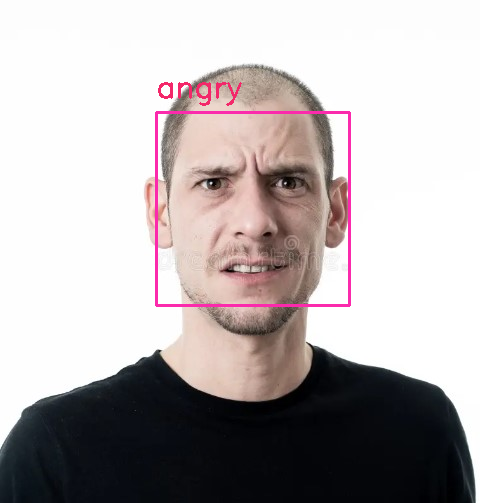

angry
[[0.40216938 0.3141524  0.12522677 0.03718207 0.02111086 0.06921404
  0.03094447]]


In [ ]:
out1,text,arr = detect_face('/content/confused_2.jpg')
cv2_imshow(out1)
print(text)
print(arr)